In [18]:
from data import Data
import os
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
Data()

for file_name in os.listdir('.'):
    if file_name.endswith('.csv'):
        print(file_name)

CSV files successfully generated
canada_cases.csv
bc_cases.csv


# Examining Data

We first examine Covid-19 data in all provinces of Canada

In [8]:
canada_data = pd.read_csv('canada_cases.csv', index_col=0)

In [9]:
canada_data

,New_Cases,New_Death,New_Recoveries,Total_Cases,Total_Death,Total_Recoveries
Date,,,,,,
2020-01-25,1,0,0,1,0,0
2020-01-26,1,0,0,2,0,0
2020-01-27,0,0,0,2,0,0
2020-01-28,1,0,0,3,0,0
2020-01-29,0,0,0,3,0,0
...,...,...,...,...,...,...
2020-12-05,6871,87,4442,413207,12628,329117
2020-12-06,7003,88,5033,420210,12716,334150
2020-12-07,6551,104,9688,426761,12820,343838


Number of days that Canada has been impacted by Covid 19

In [10]:
print(len(canada_data), 'days')

320 days


As we can see, the new cases are increasing day by day -> draw the graph

In [11]:
canada_data['New_Cases']

Date
2020-01-25       1
2020-01-26       1
2020-01-27       0
2020-01-28       1
2020-01-29       0
              ... 
2020-12-05    6871
2020-12-06    7003
2020-12-07    6551
2020-12-08    6211
2020-12-09    6358
Name: New_Cases, Length: 320, dtype: int64

Dates that Canada has more than 1000 new cases a day -> draw a line graph

In [12]:
canada_data[canada_data['New_Cases'] > 1000]

,New_Cases,New_Death,New_Recoveries,Total_Cases,Total_Death,Total_Recoveries
Date,,,,,,
2020-03-30,1112,24,529,7434,90,1114
2020-03-31,1143,36,183,8577,126,1297
2020-04-01,1599,19,439,10176,145,1736
2020-04-02,1588,25,235,11764,170,1971
2020-04-03,1199,53,352,12963,223,2323
...,...,...,...,...,...,...
2020-12-05,6871,87,4442,413207,12628,329117
2020-12-06,7003,88,5033,420210,12716,334150
2020-12-07,6551,104,9688,426761,12820,343838


In [16]:
#canada_active_cases

In [15]:
canada_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
New_Cases,320.0,1372.946875,1637.443550,0.0,338.00,678.0,1692.0,7003.0
New_Death,320.0,40.746875,50.817224,0.0,4.75,16.0,64.0,228.0
New_Recoveries,320.0,1110.553125,1909.137890,0.0,252.50,550.5,1047.0,23999.0
Total_Cases,320.0,115559.709375,102374.840597,1.0,27503.50,106669.0,146361.5,439330.0
Total_Death,320.0,6384.278125,4228.257556,0.0,930.75,8701.0,9260.0,13039.0
Total_Recoveries,320.0,88530.609375,85679.579706,0.0,8110.00,68507.0,126395.5,355377.0


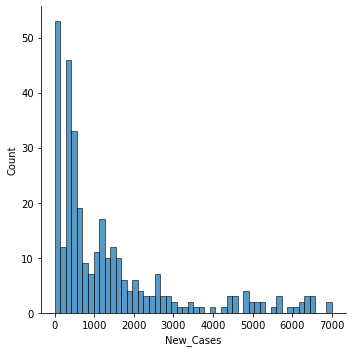

In [25]:
sns.displot(canada_data['New_Cases'], bins=50)